In [141]:
# in this code we implement a batched divergence function

import os
os.environ['JAX_PLATFORMS']="cpu"

from typing import Callable, Tuple, Any

from functools import partial


import jax 
from jax import Array
import jax.numpy as jnp
import numpy as np

# visualization
import matplotlib.pyplot as plt

In [160]:
# we define a function to compute the divergence of a vector field
# the divergence is the trace of the jacobian of the field
@partial(jax.jit, static_argnames=['vf'])
def divergence(vf: Callable, x: Array) -> Array:
    # we assume the batch dimension is the first one
    jac = jax.jacfwd(vf)(x)
    # we compute the trace of the jac
    trace = jnp.trace(jac)
    return trace
@partial(jax.jit, static_argnames=['vf'])
def batched_divergence(vf: Callable, x: Array) -> Array:
    res = jax.vmap(divergence, in_axes=(None, 0))(vf, x)
    return res

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


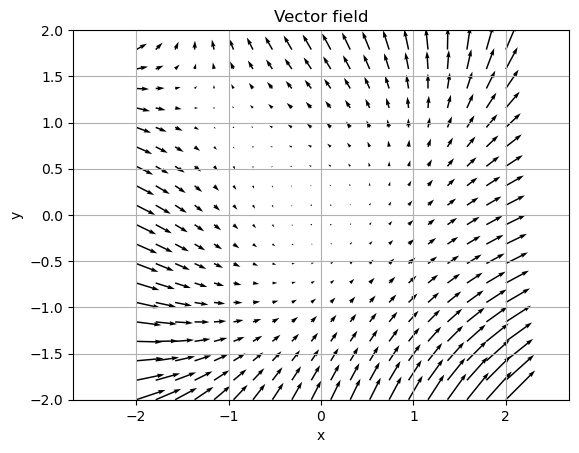

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


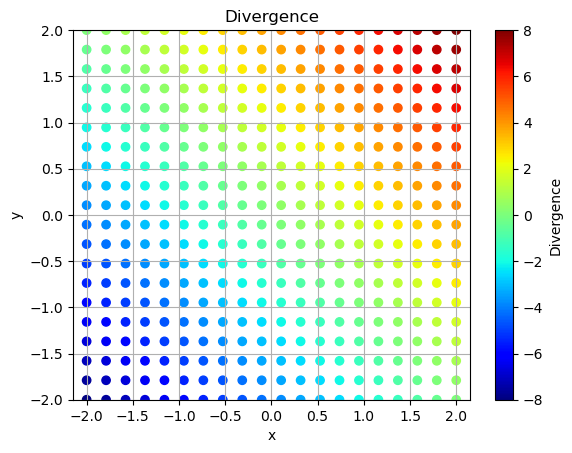

In [143]:
# define a test vector field and plot it
def test_vf(x: Array) -> Array:
    # we define a simple vector field
    return jnp.array([x[0]**2 - x[1], x[0] + x[1]**2])

# we define a grid of points
def create_grid(xmin: float, xmax: float, ymin: float, ymax: float, nx: int, ny: int) -> Array:
    x = jnp.linspace(xmin, xmax, nx)
    y = jnp.linspace(ymin, ymax, ny)
    xx, yy = jnp.meshgrid(x, y)
    grid = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)
    return grid
# we define a function to plot the vector field
def plot_vector_field(vf: Callable, grid: Array, title: str) -> None:
    # we compute the vector field at the grid points
    vf_values = jax.vmap(vf)(grid)
    # we reshape the values to the grid shape
    vf_values = vf_values.reshape(grid.shape[0], 2)
    # we plot the vector field
    plt.quiver(grid[:, 0], grid[:, 1], vf_values[:, 0], vf_values[:, 1])
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.grid()
    plt.show()

def plot_divergence(vf: Callable, grid: Array) -> None:
    # we compute the divergence at the grid points
    div_grid = batched_divergence(vf, grid)
    # we reshape the values to the grid shape
    div_grid = div_grid.reshape(grid.shape[0], 1)
    # we plot the divergence
    plt.scatter(grid[:, 0], grid[:, 1], c=div_grid, cmap='jet')
    plt.colorbar(label='Divergence')
    plt.title('Divergence')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.grid()
    plt.show()

# plot the vector field
grid = create_grid(-2, 2, -2, 2, 20, 20)
plot_vector_field(test_vf, grid, 'Vector field')
# plot the divergence
plot_divergence(test_vf, grid)

In [144]:
# Function to compute v^T * (Jacobian of F at x) * v
# This is the core term for the Hutchinson estimator
def quadratic_form_of_jacobian(F, x, v):
  """
  Computes v.T * (Jacobian of F at x) * v using jax.jvp.

  Args:
    F: The vector field function (R^n -> R^n).
    x: The point at which to compute the Jacobian.
    v: The random vector (R^n).

  Returns:
    The scalar value v^T * (Jacobian of F at x) * v.
  """
  # Compute the Jacobian-vector product: (Jacobian of F at x) * v
  # jax.jvp returns a tuple: (primal output, tangent output)
  # The tangent output is (Jacobian of F at x) * v
  _, jvp_result = jax.jvp(F, (x,), (v,))

  # Compute the dot product v^T * jvp_result
  return jnp.vdot(v, jvp_result)


# now we implement the Hutchinson divergence estimator
@partial(jax.jit, static_argnames=['vf', 'n_samples'])
def hutchinson_divergence(vf: Callable, x: Array, key, n_samples: int = 100) -> Array:
    # div(ut)(x) = E_Z[Z.T Jac(ut)(x) Z]
    def get_sample(key):
        Z = jax.random.rademacher(key, shape=(x.shape), dtype=x.dtype)
        # commpute the trace
        zT_vf_z = quadratic_form_of_jacobian(vf, x, Z)
        return zT_vf_z
    
    keys = jax.random.split(key, n_samples)
    res = jax.vmap(get_sample)(keys).mean()
    return res
    

In [145]:
key = jax.random.PRNGKey(0)
x = jax.random.normal(key, (2,))
div = divergence(test_vf, x)
h_div = hutchinson_divergence(test_vf, x, key, 2)
print("Divergence: ", div)
print("Hutchinson divergence: ", h_div)

Divergence:  0.14335775
Hutchinson divergence:  0.14335775


In [146]:
# time the two functions
%timeit divergence(test_vf, x)
%timeit hutchinson_divergence(test_vf, x, key, 2)

7.59 µs ± 1.15 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
11 µs ± 366 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [147]:
# now create a vector field with 100 components
def test_vf_100(x: Array) -> Array:
    # we define a simple vector field
    return jnp.array([x[0]**2 - x[1], x[0] + x[1]**2] + [x[i]**2 - x[i+1] for i in range(2, 100)])

In [148]:
x = jax.random.normal(key, (100,))
div = divergence(test_vf_100, x)
h_div = hutchinson_divergence(test_vf_100, x, key, 100)
print("Divergence: ", div)
print("Hutchinson divergence: ", h_div)

Divergence:  15.425986
Hutchinson divergence:  14.945984


In [149]:
%timeit divergence(test_vf_100, x)
%timeit hutchinson_divergence(test_vf_100, x, key, 1000)

90.2 µs ± 4.33 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
The slowest run took 5.90 times longer than the fastest. This could mean that an intermediate result is being cached.
33 µs ± 31.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [150]:
from flax import nnx

class MLP(nnx.Module):
    def __init__(self, input_dim: int = 2, hidden_dim: int = 128, *, rngs: nnx.Rngs):

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        din = input_dim + 1

        self.linear1 = nnx.Linear(din, self.hidden_dim, rngs=rngs)
        self.linear2 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear3 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear4 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear5 = nnx.Linear(self.hidden_dim, self.input_dim, rngs=rngs)

    def __call__(self, x: jax.Array, t: jax.Array):
        x = jnp.atleast_2d(x)
        t = jnp.atleast_1d(t)
        if len(t.shape)<2:
            t = t[..., None]
 
        t = jnp.broadcast_to(t, (x.shape[0], t.shape[-1]))
        h = jnp.concatenate([x, t], axis=-1)

        x = self.linear1(h)
        # x = self.bn1(x)
        x = jax.nn.gelu(x)

        x = self.linear2(x)
        # x = self.bn2(x)
        x = jax.nn.gelu(x)

        x = self.linear3(x)
        # x = self.bn3(x)
        x = jax.nn.gelu(x)

        x = self.linear4(x)
        # x = self.bn4(x)
        x = jax.nn.gelu(x)

        x = self.linear5(x)

        return x

In [161]:
N=50

vf_model = MLP(input_dim=N, hidden_dim=128, rngs=nnx.Rngs(0))
vf_wrapped = lambda x: vf_model(x, 0.0).flatten()
x = jax.random.normal(key, (N,))
div = divergence(vf_wrapped, x)
hdiv = hutchinson_divergence(vf_wrapped, x, key, N)
print("Divergence: ", div)
print("Hutchinson divergence: ", hdiv)

%timeit divergence(vf_wrapped, x)
%timeit hutchinson_divergence(vf_wrapped, x, key, N)

Divergence:  0.09452321
Hutchinson divergence:  -0.09478463
290 µs ± 19.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
304 µs ± 15.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [172]:
def divergence_v2(f: Callable, n: int, gaussian: bool):

    """
    Compute the divergence of a vector field using JAX.
    
    Args:
    f : Callable
        The vector field function R^n -> R^n.
    n : int
        Mode of divergence computation. -1 for exact trace, 0 for efficient exact, 
        and positive integers for stochastic estimation using Hutchinson's trace estimator.
    gaussian : bool
        Flag to use Gaussian (True) or Rademacher (False) vectors for stochastic estimation.

    Returns:
    Callable
        A function that computes the divergence at a point.
    """
    
    # Exact calculation using the trace of the Jacobian
    if n == -1:
        return jax.jit(lambda x, key: jnp.trace(jax.jacfwd(f)(x)))
    
    # Efficient exact calculation using gradients
    if n == 0:
        def div(x, key):
            fi = lambda i, *y: f(jnp.stack(y))[i]
            dfidxi = lambda i, y: jax.grad(fi, argnums=i+1)(i, *y)
            return sum(dfidxi(i, x) for i in range(x.shape[0]))
            # Not sure why vmap doesn't work here.
            # return jax.vmap(dfidxi, in_axes=(0, None))(jnp.arange(x.shape[0]), x)
        return jax.jit(div)

    # Hutchinson's trace estimator for stochastic estimation
    if n > 0:
        def div(x, key):
            def vJv(key):
                _, vjp = jax.vjp(f, x)
                v = jax.random.normal(key, x.shape, dtype=x.dtype) if gaussian else jax.random.rademacher(key, x.shape, dtype=x.dtype)
                return jnp.dot(vjp(v)[0], v)
            return jax.vmap(vJv)(jax.random.split(key, n)).mean()
        return jax.jit(div)

In [187]:
div1 = divergence_v2(vf_wrapped, -1, False)
div2 = divergence_v2(vf_wrapped, 0, False)
div3 = divergence_v2(vf_wrapped, 10000, True)

In [188]:
div1(x, key), div2(x, key), div3(x, key)

(Array(0.09452321, dtype=float32),
 Array(0.09452318, dtype=float32),
 Array(0.09635409, dtype=float32))

In [179]:
%timeit -n 10000 -r 7 div1(x, key) 
%timeit -n 10000 -r 7 div2(x, key)
# %timeit div3(x, key)

283 µs ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
242 µs ± 3.99 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [189]:
%timeit -n 1000 -r 7 div3(x, key)

8.66 ms ± 276 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
def _divergence_single(vf, x, t):
    res = jnp.trace(jax.jacfwd(vf, argnums=0)(x, t))
    return res

def _divergence_single_v2(vf, x, t):
    fi = lambda i, *y: vf(jnp.stack(y),t).flatten()[i]
    dfidxi = lambda i, y: jax.grad(fi, argnums=i+1)(i, *y)
    return sum(dfidxi(i, x) for i in range(x.shape[0]))


@partial(jax.jit, static_argnames=['vf'])
def divergence(
        vf: Callable, 
        x: Array,
        t: Array,
        ):
    """
    Compute the divergence of the vector field vf at point x and time t.
    Args:
        vf (Callable): The vector field function.
        x (Array): The point at which to compute the divergence.
        t (Array): The time at which to compute the divergence.
    Returns:
        Array: The divergence of the vector field at point x and time t.
    """
    x = jnp.atleast_2d(x)
    
    t = jnp.atleast_1d(t)
    if len(t.shape) < 2:
        t = t[..., None]
    t = jnp.broadcast_to(t, (x.shape[0], t.shape[-1]))

    return jax.vmap(_divergence_single, in_axes=(None, 0, 0))(vf, x, t)

@partial(jax.jit, static_argnames=['vf'])
def divergence_v2(
        vf: Callable, 
        x: Array,
        t: Array,
        ):
    """
    Compute the divergence of the vector field vf at point x and time t.
    Args:
        vf (Callable): The vector field function.
        x (Array): The point at which to compute the divergence.
        t (Array): The time at which to compute the divergence.
    Returns:
        Array: The divergence of the vector field at point x and time t.
    """
    x = jnp.atleast_2d(x)
    
    t = jnp.atleast_1d(t)
    if len(t.shape) < 2:
        t = t[..., None]
    t = jnp.broadcast_to(t, (x.shape[0], t.shape[-1]))

    return jax.vmap(_divergence_single_v2, in_axes=(None, 0, 0))(vf, x, t)

In [222]:
N=50

vf_model = MLP(input_dim=N, hidden_dim=128, rngs=nnx.Rngs(0))

x = jax.random.normal(key, (N,))

divergence(vf_model, x, jnp.array(0.0))
%timeit -n 10000 divergence(vf_model, x, jnp.array(0.0))

divergence_v2(vf_model, x, jnp.array(0.0))
%timeit -n 10000 divergence_v2(vf_model, x, jnp.array(0.0))

245 µs ± 4.22 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
239 µs ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [210]:
_divergence_single_v2(vf_model, x, 0.0)

Array(0.09452318, dtype=float32)

In [207]:
partial(vf_model,t=0.0)(x).shape

(1, 50)